In [1]:
import qckt
from QSystems import *
from Job import Job
import Registers as regs
import numpy as np
from math import gcd
import math

In [2]:
fxinpsz = 6
fxoutsz = 2
inpreg = regs.QRegister(fxinpsz)
outreg = regs.QRegister(fxoutsz)
clmeas = regs.CRegister(fxinpsz)
nqbits,ncbits,_,_ = regs.placement(inpreg, outreg, clmeas)

M = 2**fxinpsz

In [3]:
# setup the periodic function
fx = qckt.QCkt(nqbits)
fx.Border()
fx.CX(inpreg[-1],outreg[-1])
fx.CX(inpreg[-2],outreg[-2])
fx.Border()
print("Psst ... f(x) defined as having period of 4\n")

Psst ... f(x) defined as having period of 4



In [4]:
# QFT(x) - F(x) - QFT(x) - Measure
ckt = qckt.QCkt(nqbits,ncbits)
ckt.QFT(inpreg)
ckt = ckt.append(fx)
# actually you would expect to measure output of fx now
# ckt.M([0,1])
# but due to principle of defered measurement, it is not necessary
ckt.QFT(inpreg)
ckt.M(inpreg,clmeas)
ckt.draw()

q000 ----------#-[X]------#---------------------------------
               #  |       #                                 
q001 ----------#--|--[X]--#---------------------------------
               #  |   |   #                                 
q002 -[QFT L]--#-[.]--|---#-[QFT L]---------------------[M]-
      |     |  #      |   # |     |                      |  
q003 -[QFT  ]--#-----[.]--#-[QFT  ]-----------------[M]--|--
      |     |  #          # |     |                  |   |  
q004 -[QFT  ]--#----------#-[QFT  ]-------------[M]--|---|--
      |     |  #          # |     |              |   |   |  
q005 -[QFT  ]--#----------#-[QFT  ]---------[M]--|---|---|--
      |     |  #          # |     |          |   |   |   |  
q006 -[QFT  ]--#----------#-[QFT  ]-----[M]--|---|---|---|--
      |     |  #          # |     |      |   |   |   |   |  
q007 -[QFT M]--#----------#-[QFT M]-[M]--|---|---|---|---|--
               #          #          |   |   |   |   |   |  
creg ==========#========

In [5]:
# run the circuit many times
job = Job(ckt, qtrace=False, shots=100)
bk = Qeng()
bk.runjob(job)

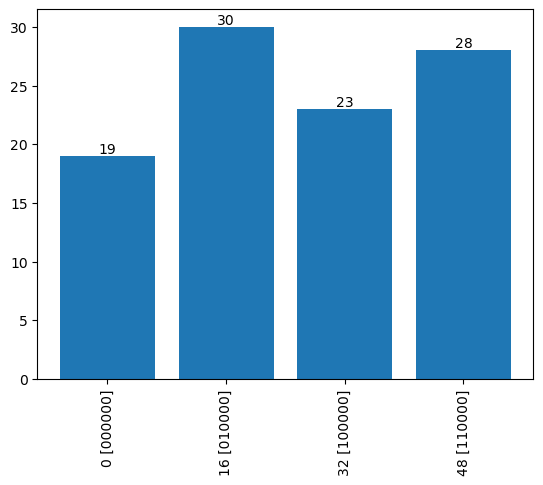

Top two measurements (other than 0) 16 48
GCD of values of multiples of M/r = 16
But, M = 64
Therefore, the period, r =  4


In [6]:
# pick the top two results other than 0  (picking top 2 will eliminate the noise)
counts = job.get_counts()
job.plot_counts()
countkv = []
for i,c in enumerate(counts): countkv.append([c,i])
for i in range(2):
	maxc = 0
	for j in range(len(counts)-i):
		if countkv[j][1] !=0 and countkv[j][0] > maxc:
			maxc = countkv[j][0]
			maxi = countkv[j][1]
	# swap
	t = countkv[len(counts)-i-1]
	countkv[len(counts)-i-1] = [maxc,maxi]
	countkv[maxi] = t

# find the GCD of the two values read to get M/r, and compute r, as M is known
print("Top two measurements (other than 0)",countkv[-1][1], countkv[-2][1])
mbyr = int(math.gcd(countkv[-1][1], countkv[-2][1]))
print("GCD of values of multiples of M/r = {:d}".format(mbyr))
print("But, M =", M)
r = int(M / mbyr)
print("Therefore, the period, r = ",r)